# YELP DATASET


# Goal: Using user information to improve restaurants quality


### One: Review 
> #### Is there a common theme in users' first review? If yes, what is the prevelant theme? 

### Two: Elite User Program: 

> #### a. What factors make a user become elite? ( Quality vs Quantity ) 
>
#### b. Is there a trend in users'reviews? If yes, what subtopics they usually pay attention to? 
>
#### c. How many year each user maintain the elite status? 
>
#### d. Is there any user who has quality review and/or with high quantity that does not have elite status? Does it affect there loyalty for yelp?
>
#### e. Do most people leave reviews when they travel?

### Three: Tip 
> #### Correlation between tips & reviews. What makes one to leave tips? Tips predictions.


Dataset Source: https://www.yelp.com/dataset_challenge

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition.online_lda import LatentDirichletAllocation
import string
from sklearn.pipeline import Pipeline

Populating the interactive namespace from numpy and matplotlib


# Read Data

In [4]:
user = pd.read_csv('csv/user.csv')
business = pd.read_csv('csv/business.csv')
review = pd.read_csv('csv/review.csv')
tip = pd.read_csv('csv/tip.csv')

/Users/Charlotte/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,4,7,17,26,29,49,60,62,79,86,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
def rename_column(file):
    new_names = list()
    for col in file:
        new_names.append(col.replace('.', '_', len(col)).replace(' ', '_', len(col)).lower())
    return new_names

In [9]:
user.columns = rename_column(user.columns)
business.columns = rename_column(business.columns)
business.columns = [ re.sub('attributes_', '', c) for c in business.columns ]
review.columns = rename_column(review.columns)

In [10]:
user = user.ix[user['review_count'] != 0]
user = user.drop(['type','friends'],axis = 1 )

In [11]:
review = review.drop('type',axis = 1)
business = business.drop('type',axis = 1)
tip = tip.drop('type',axis = 1)

In [12]:
user = user.reset_index()

# Data visualization

## Business Rating

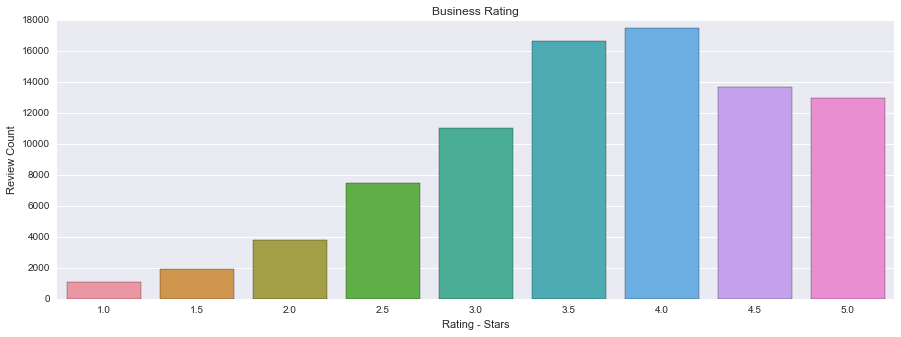

In [87]:
plt.figure(figsize=(15,5))
sns.countplot(business['stars'])
plt.title('Business Rating')
plt.xlabel('Rating - Stars')
plt.ylabel('Review Count')

## Elite Status

In [21]:
# to find how many users in each elite year period
user['elite_year']  = [ len(i.split(',')) for i in user['elite']]

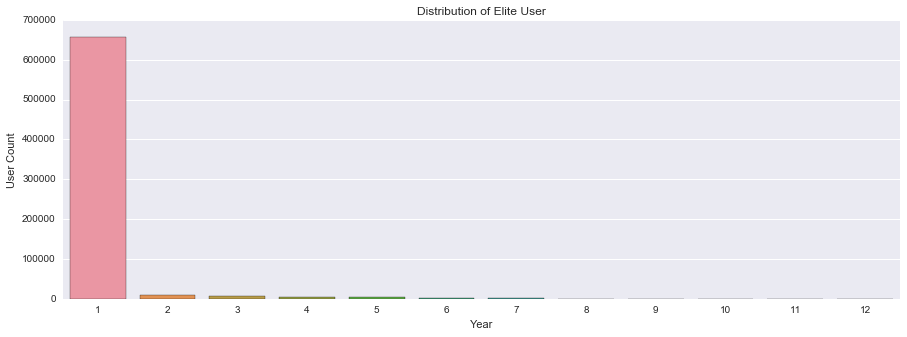

In [22]:
plt.figure(figsize=(15,5))
sns.countplot(user['elite_year'])
plt.title('Distribution of Elite User')
plt.xlabel('Year')
plt.ylabel('User Count')

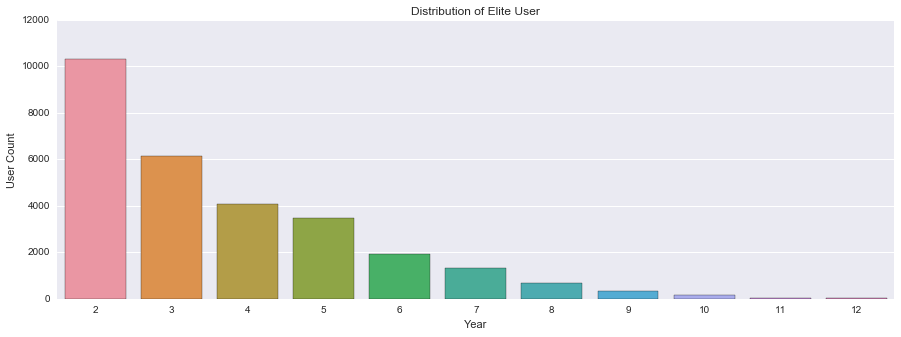

In [23]:
plt.figure(figsize=(15,5))
sns.countplot(user['elite_year'].ix[user['elite_year'] != 1])
plt.title('Distribution of Elite User')
plt.xlabel('Year')
plt.ylabel('User Count')

# Number of years since  Yelp Membership Start Year until Elite Status

In [24]:
user['elite_since'] = [i.replace('[','').replace(']','').split(',')[0] for i in user['elite']]

In [25]:
user['elite_since'] = [int(i) if i!= '' else 0 for i in user['elite_since'] ]

In [26]:
user['year_before_elite'] = [ user['elite_since'][i] - int(user['yelping_since'][i].split("-")[0]) if  user['elite_since'][i]!= 0 else 0 for i in range(686543)]

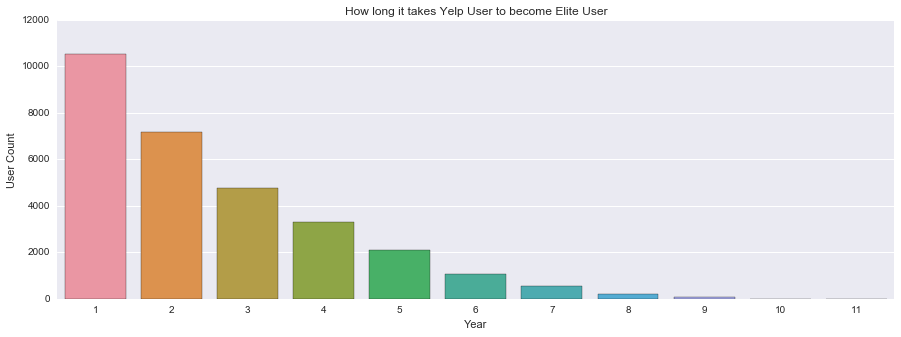

In [27]:
plt.figure(figsize=(15,5))
sns.countplot(user['year_before_elite'].ix[user['year_before_elite']!= 0])
plt.title('How long it takes Yelp User to become Elite User')
plt.xlabel('Year')
plt.ylabel('User Count')

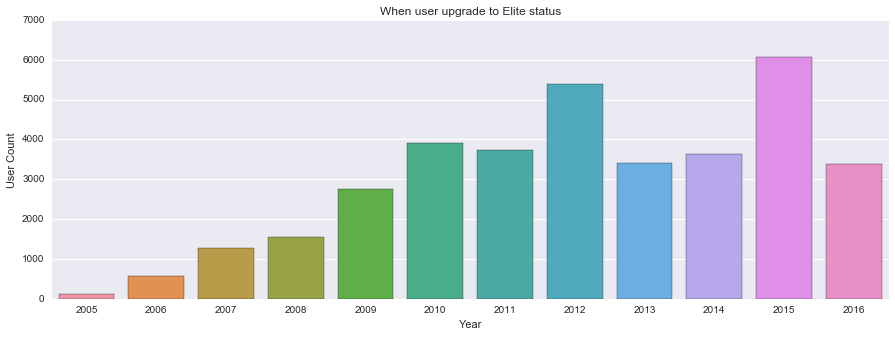

In [28]:
plt.figure(figsize=(15,5))
sns.countplot(user['elite_since'].ix[user['elite_since']!= 0])
plt.title('When user upgrade to Elite status')
plt.xlabel('Year')
plt.ylabel('User Count')

In [31]:
elite_dict = Counter(user['year_before_elite'])

In [89]:
elite_pd = pd.DataFrame(list(elite_dict.items()),index = None,columns = ['year','user_count'])

In [33]:
member_since = user.groupby('yelping_since')['user_id'].count()
member_since = pd.DataFrame(member_since)

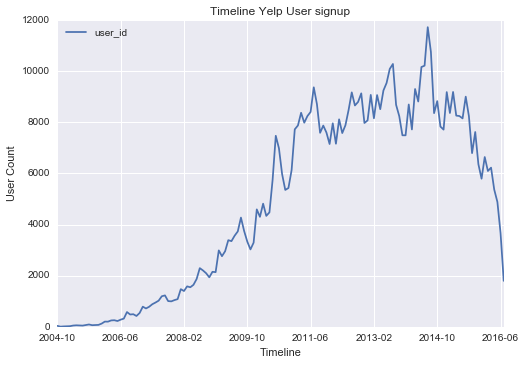

In [88]:
member_since.plot()
plt.title('Timeline Yelp User signup')
plt.xlabel('Timeline')
plt.ylabel('User Count')

# Review

In [36]:
a = Counter(review.user_id)
b = Counter(a.values()) # key : #review -- value: user count
b = dict(b)

In [37]:
c = pd.DataFrame(list(b.items()),index = None,columns = ['review','user_count'])
print(len(c))
c.head(2)

447


,review,user_count
0,1,360566
1,2,115750


In [38]:
c['percentage'] = [(c.user_count[i] * 100/sum(c.user_count)) for i in range(447)]

In [39]:
reviews_dict = dict()
label = ['one','two','three']
for i,label in enumerate(label):
    reviews_dict[label] = c.percentage[i]

In [40]:
reviews_dict['four_ten']= sum(c.percentage[3:10])
reviews_dict['tens']= sum(c.percentage[10:100])
reviews_dict['more_than_hundred']= sum(c.percentage[100:-1])

In [41]:
reviews_dict

{'four_ten': 15.839057556848969,
 'more_than_hundred': 0.244699631202698,
 'one': 52.518075728709675,
 'tens': 5.975477601244473,
 'three': 8.5630305466706282,
 'two': 16.859513280781176}

In [42]:
review_pd = pd.DataFrame(list(reviews_dict.items()),index = None,columns = ['review','user_percentage'])
review_pd

,review,user_percentage
0,four_ten,15.839058
1,one,52.518076
2,three,8.563031
3,more_than_hundred,0.244700
4,two,16.859513
5,tens,5.975478


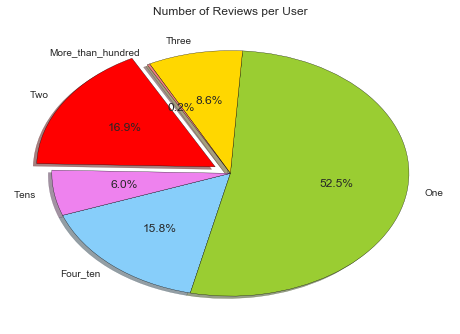

In [43]:
labels =[ i.capitalize() for i in  review_pd['review']]
sizes = review_pd['user_percentage']
colors = ['lightskyblue','yellowgreen', 'gold', 'lightcoral','red','violet']
explode = (0, 0, 0,0,.1, 0) 

plt.pie(sizes, explode=explode,labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=200,center=(0,1));
plt.title('Number of Reviews per User')

# Filter business category to restaurant only

In [44]:
# create a dataframe with business id and category
all_businesses = pd.concat([business['business_id'], business['categories']], axis=1, keys=['business_id', 'category'])

In [45]:
all_businesses.head(3)

,business_id,category
0,5UmKMjUEUNdYWqANhGckJw,"['Fast Food', 'Restaurants']"
1,UsFtqoBl7naz8AVUBZMjQQ,['Nightlife']
2,cE27W9VPgO88Qxe4ol6y_g,"['Active Life', 'Mini Golf', 'Golf']"


In [46]:
# get index of businesses that are not restaurants
not_restaurant = [i for i,e in enumerate(all_businesses.values) if "Restaurant" not in e[1]]
all_businesses.drop(all_businesses.index[not_restaurant], inplace=True)
restaurant = all_businesses # after dropping all businesses that are not restaurants 

In [47]:
restaurant = restaurant.reset_index() # reset the index 

In [48]:
restaurant = restaurant.drop('index',axis = 1) # drop the old index 

In [52]:
# len(restaurant) # 26729 -- number of businesses
# len(restaurant.category.unique()) #4318--- number of unique categories 

In [53]:
k = Counter(restaurant.category) # 4318 -- Count number of businesses / unique category --- most categories are very similar 

In [54]:
label = [k for k,v in k.items() if v >100] # 41 --- get the label that has more than 100 businesses

In [55]:
label[:5]

["['Japanese', 'Restaurants']",
 "['Canadian (New)', 'Restaurants']",
 "['Delis', 'Fast Food', 'Sandwiches', 'Restaurants']",
 "['Italian', 'Pizza', 'Restaurants']",
 "['French', 'Restaurants']"]

# Get Reviews for Restaurants only

In [59]:
review_indices = review['business_id'].isin(restaurant['business_id'])

In [60]:
restaurant_review = review[review_indices]

In [62]:
review_count = Counter(restaurant_review['business_id']) ### number of restaurants
print(len(review_count))
top_restaurant = [(k,v)for k,v in review_count.items() if v > 300]#number of restaurants that have more than 300 reviews
top_restaurant[:10]
sorted_by_second = sorted(top_restaurant, key=lambda tup: tup[1])
sorted_by_second[-5:]

26629


[('2e2e7WgqU1BnpxmQL5jbfw', 4103),
 ('aGbjLWzcrnEx2ZmMCFm3EA', 4149),
 ('zt1TpTuJ6y9n551sw9TaEg', 4333),
 ('sIyHTizqAiGu12XMLX3N3g', 4531),
 ('4bEjOyTaDG24SY5TxsaUNQ', 5558)]

In [90]:
selected_restaurants = pd.DataFrame(sorted_by_second,columns = ['business_id','review_count'])
selected_restaurants.tail(2)

,business_id,review_count
935,sIyHTizqAiGu12XMLX3N3g,4531
936,4bEjOyTaDG24SY5TxsaUNQ,5558


In [72]:
user.columns

Index(['index', 'yelping_since', 'compliments_plain', 'review_count',
       'compliments_cute', 'compliments_writer', 'fans', 'compliments_note',
       'compliments_hot', 'compliments_cool', 'compliments_profile',
       'average_stars', 'compliments_more', 'elite', 'name', 'user_id',
       'votes_cool', 'compliments_list', 'votes_funny', 'compliments_photos',
       'compliments_funny', 'votes_useful', 'elite_year', 'elite_since',
       'year_before_elite'],
      dtype='object')

In [74]:
elite_user = (user['user_id'].ix[user['elite_since'] != 0])

In [75]:
not_elite_user = (user['user_id'].ix[user['elite_since'] == 0])

In [76]:
elite_index = user[user['elite_since'] != 0].index.tolist()

In [77]:
# not_elite_index = user[user['elite_since'] == 0].index.tolist()

In [78]:
review_index = restaurant_review['user_id'].isin(elite_user )

In [79]:
not_elite_index = restaurant_review['user_id'].isin(not_elite_user)

In [80]:
elite_review = restaurant_review[review_index ]

In [81]:
not_elite_review = restaurant_review[not_elite_index]